<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png" width=50%/>

<h1><font color='#12007a'>Procesamiento de Lenguaje Natural con Aprendizaje Profundo</font></h1>
<p>Autora: Isabel Segura Bedmar</p>

<img align='right' src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center>  


# Práctica 1 - SemEval 2023 - Task 10 - Explainable Detection of Online Sexism (EDOS)

En este notebook,estudiaremos el conjunto de datos para la tarea EDOS (https://codalab.lisn.upsaclay.fr/competitions/7124). El objetivo de esta tarea  es desarrollar sistemas automáticos que permitan identificar contenidos sexistas y dar más explicaciones al respecto.

El dataset se puede descargar desde https://github.com/rewire-online/edos/tree/main/data. En concreto, el dataset consta de 20.000 instancias o mensajes (10.000 son de Gab y 10.000 de Reddit).



**NOTA PARA PODER EJECUTAR ESTE NOTEBOOK**:

1) Para poder ejercutar correctamente este notebook, deberás abrirlo en tu Google Drive (por ejemplo, en la carpeta 'Colab Notebooks').

2) Además, debes guardar el dataset en tu Google Drive, dentro de carpeta 'Colab Notebooks/data/edos/'.






## Cargar el dataset


In [41]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/data/edos/')

import pandas as pd
df = pd.read_csv("edos_labelled.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,none,none,dev
1,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,none,none,train
2,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,none,none,train
3,sexism2022_english-13021,woman?,not sexist,none,none,train
4,sexism2022_english-966,I bet she wished she had a gun,not sexist,none,none,dev


La columna 'split' nos permite conocer a que partición pertenece cada mensaje.


In [42]:
df['split'].unique()

array(['dev', 'train', 'test'], dtype=object)

El conjunto de datos completo contiene tres divisiones (entrenamiento, desarrollo y prueba) con una proporción de 70:10:20.

Guardamos cada split en un dataframe diferente para poder estudiarlo posteriormente:

In [43]:
df_train = df[df['split']=='train'] # for training
df_dev = df[df['split']=='dev'] # for validation
df_test = df[df['split']=='test'] # for final test

print('tamaño del conjunto de entrenamiento: ', df_train.shape)
print('tamaño del conjunto de validación: ', df_dev.shape)
print('tamaño del conjunto de test: ', df_test.shape)

tamaño del conjunto de entrenamiento:  (14000, 6)
tamaño del conjunto de validación:  (2000, 6)
tamaño del conjunto de test:  (4000, 6)


Vamos a mostrar algunas instancias (ejecuta esta celda varias veces para ver distintas instancias):

In [44]:
import random
index = random.randint(0,df_train.shape[0])
print(index, df_train.iloc[index]['text'])
print(index, df_train.iloc[index]['label_sexist']) # tarea A
print(index, df_train.iloc[index]['label_category']) # tarea B
print(index, df_train.iloc[index]['label_vector']) # tarea C

11850 Ok. Let me try and clear up this misconception. Again. Just because you would be justified in using deadly force against someone doesn't mean you have to ensure that they die.
11850 not sexist
11850 none
11850 none


## Distribución de clases
Vamos a estudiar la distribución de las clases para cada tarea (A, B y C), y también vamos a ver si esa distribución es igual en los tres splits.
Es de esperar que así sea, porque los organizadores deben haber creado los splits garantizando que la distribución se mantiene.


### Distribución de clases para la tarea A (clasificación binaria de mensajes sexistas)


In [45]:
data_train1 = df_train["label_sexist"].value_counts().reset_index()
data_train1.columns = ['label_sexist', 'counts']

data_dev1 = df_dev["label_sexist"].value_counts().reset_index()
data_dev1.columns = ['label_sexist', 'counts']

data_test1 = df_test["label_sexist"].value_counts().reset_index()
data_test1.columns = ['label_sexist', 'counts']

data_all = df["label_sexist"].value_counts().reset_index()
data_all.columns = ['label_sexist', 'counts']


print("Distribución de clases (training):", data_train1.to_dict())
print("Distribución de clases (validation):", data_dev1.to_dict())
print("Distribución de clases (test):", data_test1.to_dict())
print("Distribución de clases (completo):", data_all.to_dict())


Distribución de clases (training): {'label_sexist': {0: 'not sexist', 1: 'sexist'}, 'counts': {0: 10602, 1: 3398}}
Distribución de clases (validation): {'label_sexist': {0: 'not sexist', 1: 'sexist'}, 'counts': {0: 1514, 1: 486}}
Distribución de clases (test): {'label_sexist': {0: 'not sexist', 1: 'sexist'}, 'counts': {0: 3030, 1: 970}}
Distribución de clases (completo): {'label_sexist': {0: 'not sexist', 1: 'sexist'}, 'counts': {0: 15146, 1: 4854}}


Observando los dataframes que hemos creado a partir de contar las instancias de cada clase, podemos ver facilmente que la clase 0 (no sexista) es mucho más frecuente que la clase 1 (sexista). Por tanto, estamos ante un problema de desbalanceado de datos, lo que va a dificultar la correcta clasificación de las instancias de la clase con menos ejemplos (es decir, la clase sexista).
Vamos a mostrar esta información también en tres gráficos:

<ipython-input-46-f539a469f6f3>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_train.set_xticklabels(data_train1['label_sexist'], rotation=45)
<ipython-input-46-f539a469f6f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_dev.set_xticklabels(data_dev1['label_sexist'], rotation=45)
<ipython-input-46-f539a469f6f3>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_test.set_xticklabels(data_test1['label_sexist'], rotation=45)


Text(0.5, 1.0, 'Test')

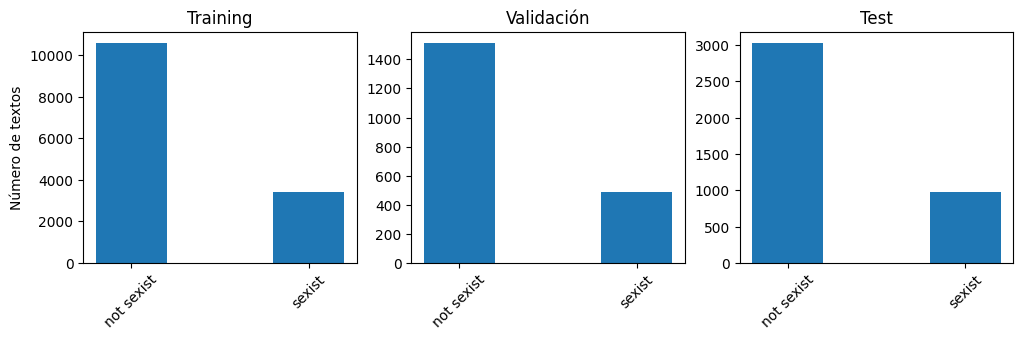

In [46]:
import matplotlib.pyplot as plt

fig, (ax_train, ax_dev, ax_test) = plt.subplots(1, 3, figsize=(12, 3))
# fig.suptitle('Distribution of the languages in both subsets: training and test')
ax_train.bar(data_train1['label_sexist'], data_train1['counts'], width=0.4)
ax_train.set_xticklabels(data_train1['label_sexist'], rotation=45)
ax_train.set_title('Training')
ax_train.set_ylabel('Número de textos')

ax_dev.bar(data_dev1['label_sexist'], data_dev1['counts'], width=0.4)
ax_dev.set_xticklabels(data_dev1['label_sexist'], rotation=45)
ax_dev.set_title('Validación')

ax_test.bar(data_test1['label_sexist'], data_test1['counts'], width=0.4)
ax_test.set_xticklabels(data_test1['label_sexist'], rotation=45)
ax_test.set_title('Test')


Como era de esperar, la misma distribución se observó en los tres splits (que fueron proporcionados por los organizadores).

Lo mismo ocurre, si mostramos el gráfico con la distribución de clases para todo el conjunto de datos.

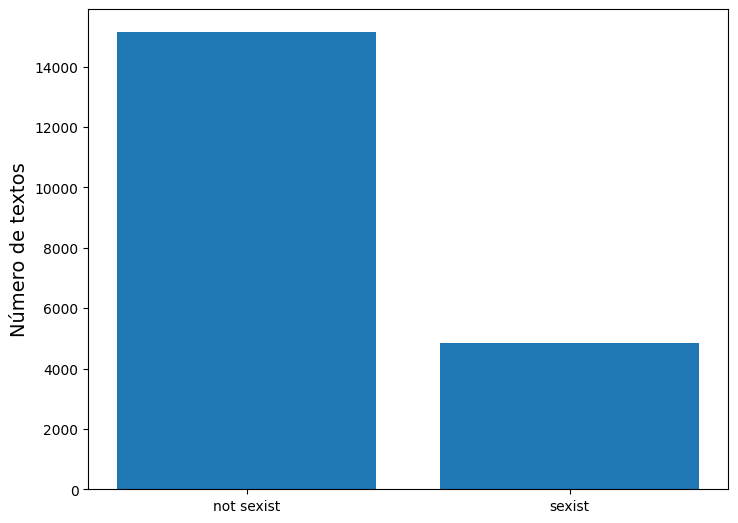

In [47]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(data_all['label_sexist'],data_all['counts'])
ax.set_ylabel('Número de textos', fontsize = 14)
plt.show()




En estos gráficos, se ve claramente que la clase minorista es 'sexist'.


### Distribución de clases para la tarea B (clasificación de mensajes sexistas).

Estudiamos ahora la distribución para los valores de la columna 'label_category' (que contiene las clases de las instancias para la tarea B).

Estas clases son:
- 1. threats, plans to harm and incitement
- 2. derogation
- 3. animosity
- 4. prejudiced discussions

Recuerda que estas clases únicamente se aplican a los mensajes sexistas, por tanto debemos ignorar las instancias clasificadas como no sexistas en el campo 'label_sexist'.



In [48]:
df_train_sex = df_train[df_train['label_sexist']=='sexist']
df_dev_sex = df_dev[df_dev['label_sexist']=='sexist']
df_test_sex = df_test[df_test['label_sexist']=='sexist']
df_sex = df[df['label_sexist']=='sexist']

print('Tamaño training para tareas B y C', df_train_sex.shape)
print('Tamaño del conjunto de validación para tareas B y C', df_dev_sex.shape)
print('Tamaño del conjunto test para tareas B y C', df_test_sex.shape)
print('Tamaño de todo el dataset para tareas B y C', df_sex.shape)


Tamaño training para tareas B y C (3398, 6)
Tamaño del conjunto de validación para tareas B y C (486, 6)
Tamaño del conjunto test para tareas B y C (970, 6)
Tamaño de todo el dataset para tareas B y C (4854, 6)


Vamos a mostrar algunas instancias para la tarea B

In [49]:
index = random.randint(0,df_train_sex.shape[0])
print(index, df_train_sex.iloc[index]['text'])
print(index, df_train_sex.iloc[index]['label_category'])

2112 I personally would have hit that bitch and she'd never have done it again.
2112 1. threats, plans to harm and incitement


Ahora obtenemos para cada clase, el número de veces que está presente en cada split:

In [50]:
data_train2 = df_train_sex["label_category"].value_counts().reset_index()
data_train2.columns = ['label_category', 'counts']

data_dev2 = df_dev_sex["label_category"].value_counts().reset_index()
data_dev2.columns = ['label_category', 'counts']

data_test2 = df_test_sex["label_category"].value_counts().reset_index()
data_test2.columns = ['label_category', 'counts']

data_all = df_sex["label_category"].value_counts().reset_index()
data_all.columns = ['label_category', 'counts']


In [51]:
data_train2

,label_category,counts
0,2. derogation,1590
1,3. animosity,1165
2,4. prejudiced discussions,333
3,"1. threats, plans to harm and incitement",310


In [52]:
data_dev2

,label_category,counts
0,2. derogation,227
1,3. animosity,167
2,4. prejudiced discussions,48
3,"1. threats, plans to harm and incitement",44


In [53]:
data_test2

,label_category,counts
0,2. derogation,454
1,3. animosity,333
2,4. prejudiced discussions,94
3,"1. threats, plans to harm and incitement",89


Podemos ver que la clase mayoritaria en los tres splits es siempre la clase '2. derogation', seguida de '3.animosity'. Las clases 4 y 1 tienen un tamaño mucho menor que las dos anteriores, y por tanto, es de esperar que los modelos obtengan peores resultados en estas clases.

Vamos a mostrarlos en un gráfico de barras (asignamos un color a cada categoria):

In [54]:
colors = ['orchid', 'lightsalmon', 'yellowgreen','deepskyblue']
labels = sorted(data_train2['label_category'].tolist())
# print(labels)

dict_color = dict(zip(labels, colors))
dict_color

color_train = data_train2['label_category'].apply(lambda x: dict_color[x]).tolist()
color_dev = data_dev2['label_category'].apply(lambda x: dict_color[x]).tolist()
color_test = data_test2['label_category'].apply(lambda x: dict_color[x]).tolist()
color_all = data_all['label_category'].apply(lambda x: dict_color[x]).tolist()

# print(color_train)
# print(color_dev)
# print(color_test)

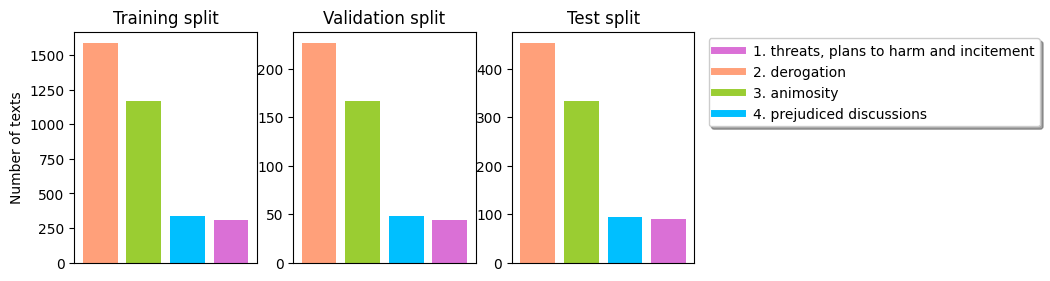

In [55]:
from matplotlib.lines import Line2D

fig, (ax_train, ax_dev, ax_test) = plt.subplots(1, 3, figsize=(8, 3))
ax_train.bar(data_train2['label_category'], data_train2['counts'], label=dict_color.keys(), color=color_train)
# ax_train.set_xticklabels(data_train['label_category'], rotation=45)
ax_train.set_title('Training split')
ax_train.set_ylabel('Number of texts')
ax_train.axes.get_xaxis().set_ticks([]) #hide the labels



ax_dev.bar(data_dev2['label_category'], data_dev2['counts'], label=dict_color.keys(), color=color_dev)
#ax_dev.set_xticklabels(counts_dev['label_category'], rotation=45)
ax_dev.axes.get_xaxis().set_ticks([])  #hide the labels

ax_dev.set_title('Validation split')

ax_test.bar(data_test2['label_category'], data_test2['counts'], label=dict_color.keys(), color=color_test)
#ax_test.set_xticklabels(counts_test['label_category'], rotation=45)
ax_test.axes.get_xaxis().set_ticks([])  #hide the labels

ax_test.set_title('Test split')


# plt.legend()

lines = [Line2D([0], [0], color=c, linewidth=5) for c in colors]
plt.legend(lines, dict_color.keys(), ncol=1, bbox_to_anchor=(1.04, 1), loc="upper left", fancybox=True, shadow=True)
plt.show()




El gráfico nos muestra más facilmente lo que hemos dicho anteriormente. Las clases 2 y 3 son las más frecuentes, y las clases 4 y 1, tienen muchas menos instancias. Como era de esperar el mismo comportamiento se da en los tres splits.

Si consideramos todo el dataset, la distribución también va a ser la misma:

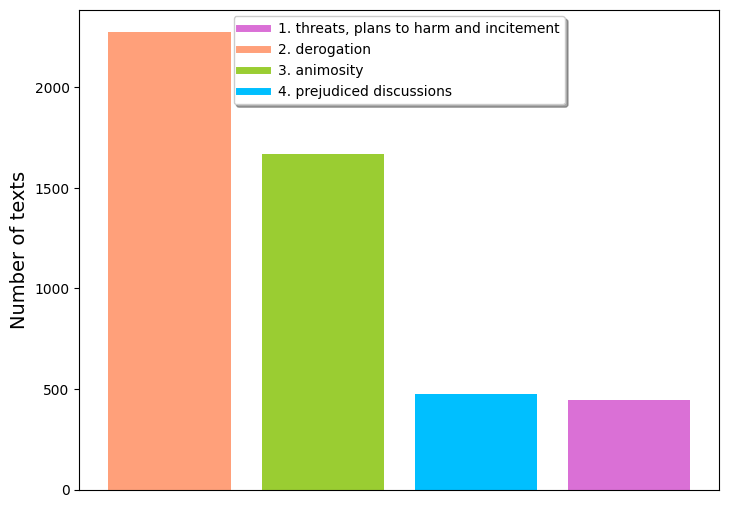

In [56]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.bar(data_all['label_category'], data_all['counts'], label=dict_color.keys(), color=color_train)
# ax_train.set_xticklabels(data_train['label_category'], rotation=45)
ax.set_ylabel('Number of texts', fontsize = 14)
ax.axes.get_xaxis().set_ticks([]) #hide the labels

# plt.legend()

lines = [Line2D([0], [0], color=c, linewidth=5) for c in colors]
plt.legend(lines, dict_color.keys(), ncol=1, loc="upper center", fancybox=True, shadow=True)
plt.show()

### Distribución de clases para la tarea C (clasificaicón de grano fino en 11 vectores).

Ahora tenemos que contar las instancias para cada una de las clases del campo "label_vector". Las posibles clases son:
- '1.1 threats of harm'',
-  '1.2 incitement and encouragement of harm',
-  '2.1 descriptive attacks',
-  '2.2 aggressive and emotive attacks',
-  '2.3 dehumanising attacks & overt sexual objectification',
-  '3.1 casual use of gendered slurs, profanities, and insults',
-  '3.2 immutable gender differences and gender stereotypes',
-  '3.3 backhanded gendered compliments',
-  '3.4 condescending explanations or unwelcome advice',
-  '4.1 supporting mistreatment of individual women',
-  '4.2 supporting systemic discrimination against women as a group']

In [57]:
data_train3 = df_train_sex["label_vector"].value_counts().reset_index()
data_train3.columns = ['label_vector', 'counts']

data_dev3 = df_dev_sex["label_vector"].value_counts().reset_index()
data_dev3.columns = ['label_vector', 'counts']

data_test3 = df_test_sex["label_vector"].value_counts().reset_index()
data_test3.columns = ['label_vector', 'counts']

data_all3 = df_sex["label_vector"].value_counts().reset_index()
data_all3.columns = ['label_vector', 'counts']

In [58]:
labels3= sorted(data_train3['label_vector'])
labels3


['1.1 threats of harm',
 '1.2 incitement and encouragement of harm',
 '2.1 descriptive attacks',
 '2.2 aggressive and emotive attacks',
 '2.3 dehumanising attacks & overt sexual objectification',
 '3.1 casual use of gendered slurs, profanities, and insults',
 '3.2 immutable gender differences and gender stereotypes',
 '3.3 backhanded gendered compliments',
 '3.4 condescending explanations or unwelcome advice',
 '4.1 supporting mistreatment of individual women',
 '4.2 supporting systemic discrimination against women as a group']

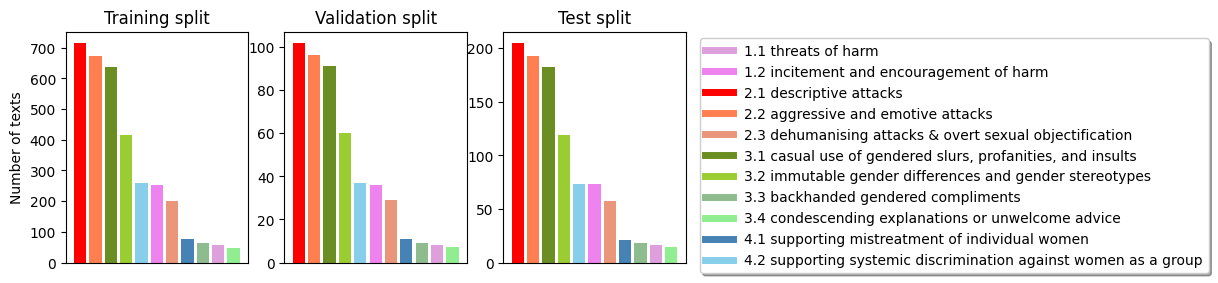

In [59]:
# dos primeras un orchid , son de la clase 1
# tres siguientes deben ser de color rojizo
# las 4 siguientes son la clase 3, debe tener un color verde
# los dos últimos azules
colors3 = ['plum', 'violet',
           'red', 'coral', 'darksalmon',
           'olivedrab', 'yellowgreen', 'darkseagreen', 'lightgreen',
           'steelblue', 'skyblue' ]

labels3 = sorted(data_train3['label_vector'].tolist())
# print(labels3)

dict_color3 = dict(zip(labels3, colors3))


color_train3 = data_train3['label_vector'].apply(lambda x: dict_color3[x]).tolist()
color_dev3 = data_dev3['label_vector'].apply(lambda x: dict_color3[x]).tolist()
color_test3 = data_test3['label_vector'].apply(lambda x: dict_color3[x]).tolist()
color_all3 = data_all3['label_vector'].apply(lambda x: dict_color3[x]).tolist()

# print(color_train)
# print(color_dev)
# print(color_test)



fig, (ax_train, ax_dev, ax_test) = plt.subplots(1, 3, figsize=(8, 3))
ax_train.bar(data_train3['label_vector'], data_train3['counts'], label=dict_color3.keys(), color=color_train3)
ax_train.set_title('Training split')
ax_train.set_ylabel('Number of texts')
ax_train.axes.get_xaxis().set_ticks([]) #hide the labels



ax_dev.bar(data_dev3['label_vector'], data_dev3['counts'], label=dict_color3.keys(), color=color_dev3)
ax_dev.axes.get_xaxis().set_ticks([])  #hide the labels
ax_dev.set_title('Validation split')

ax_test.bar(data_test3['label_vector'], data_test3['counts'], label=dict_color3.keys(), color=color_test3)
ax_test.axes.get_xaxis().set_ticks([])  #hide the labels

ax_test.set_title('Test split')



lines = [Line2D([0], [0], color=c, linewidth=5) for c in colors3]
plt.legend(lines, dict_color3.keys(), ncol=1, bbox_to_anchor=(1.04, 1), loc="upper left", fancybox=True, shadow=True)
plt.show()



Los tres splits muestran la misma distribución como era de esperar. Las tres clases o vectores con mayor número de instancias son: 2.1, 2.2 y 3.1.
La clase con menor número de instancias es 3.4.


Si consideramos todo el dataset, la distribución es la misma:

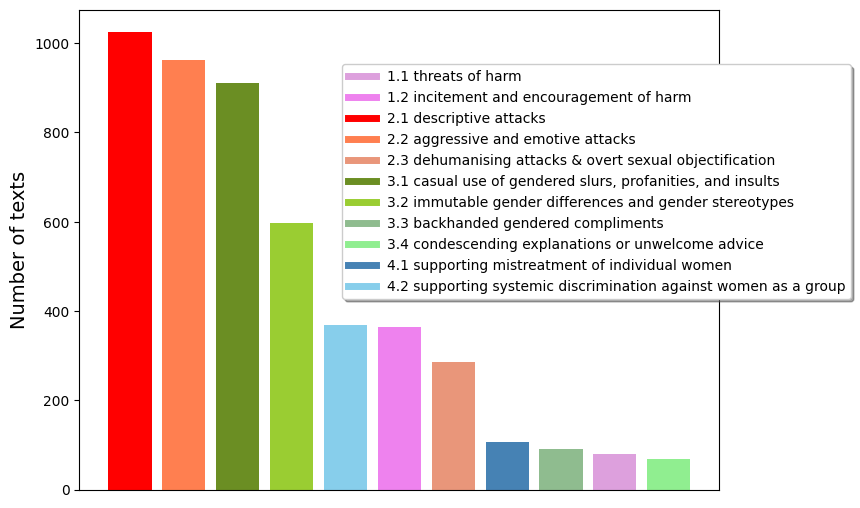

In [60]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.bar(data_all3['label_vector'], data_all3['counts'], label=dict_color3.keys(), color=color_all3)
# ax_train.set_xticklabels(data_train['label_category'], rotation=45)
ax.set_ylabel('Number of texts', fontsize = 14)
ax.axes.get_xaxis().set_ticks([]) #hide the labels

# plt.legend()

lines = [Line2D([0], [0], color=c, linewidth=5) for c in colors3]
plt.legend(lines, dict_color3.keys(), ncol=1, bbox_to_anchor=(0.4, 0.9), loc="upper left", fancybox=True, shadow=True)
plt.show()

In [61]:
data_train3

,label_vector,counts
0,2.1 descriptive attacks,717
1,2.2 aggressive and emotive attacks,673
2,"3.1 casual use of gendered slurs, profanities,...",637
3,3.2 immutable gender differences and gender st...,417
4,4.2 supporting systemic discrimination against...,258
5,1.2 incitement and encouragement of harm,254
6,2.3 dehumanising attacks & overt sexual object...,200
7,4.1 supporting mistreatment of individual women,75
8,3.3 backhanded gendered compliments,64
9,1.1 threats of harm,56


In [62]:
data_dev3

,label_vector,counts
0,2.1 descriptive attacks,102
1,2.2 aggressive and emotive attacks,96
2,"3.1 casual use of gendered slurs, profanities,...",91
3,3.2 immutable gender differences and gender st...,60
4,4.2 supporting systemic discrimination against...,37
5,1.2 incitement and encouragement of harm,36
6,2.3 dehumanising attacks & overt sexual object...,29
7,4.1 supporting mistreatment of individual women,11
8,3.3 backhanded gendered compliments,9
9,1.1 threats of harm,8


In [63]:
data_test3

,label_vector,counts
0,2.1 descriptive attacks,205
1,2.2 aggressive and emotive attacks,192
2,"3.1 casual use of gendered slurs, profanities,...",182
3,3.2 immutable gender differences and gender st...,119
4,4.2 supporting systemic discrimination against...,73
5,1.2 incitement and encouragement of harm,73
6,2.3 dehumanising attacks & overt sexual object...,57
7,4.1 supporting mistreatment of individual women,21
8,3.3 backhanded gendered compliments,18
9,1.1 threats of harm,16


## Distribución del tamaño de los textos (número de tokens)

Conocer el tamaño de los textos de entrada siempre es necesario para poder decidir qué tamaño de entrada vamos a usar para representar nuestros textos.

Además, también nos puede ofrecer información interesante sobre, si por ejemplo, los mensajes sexistas son más cortos que los que no son sexistas.

Vamos a añadir un nuevo campo a los dataframes y vamos a guardar en él, el número de tokens de su texto asociado.

Esto podríamos hacerlo con un tokenziador (y sería más correcto), sin embargo, el método split nos uede dar una estimación bastante acertada de cómo es la distribución de los números de tokens en los textos. Además, el método split es más eficiente que los tokenizadores, es decir, para obtener una estimación, es más que suficiente:


In [64]:
df["length"]=df['text'].apply(lambda x: len(x.split()))

df_train["length"]=df_train['text'].apply(lambda x: len(x.split()))
df_dev["length"]=df_dev['text'].apply(lambda x: len(x.split()))
df_test["length"]=df_test['text'].apply(lambda x: len(x.split()))


<ipython-input-64-b7e12eea397e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["length"]=df_train['text'].apply(lambda x: len(x.split()))
<ipython-input-64-b7e12eea397e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dev["length"]=df_dev['text'].apply(lambda x: len(x.split()))
<ipython-input-64-b7e12eea397e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [65]:
df['length'].describe(percentiles=[0, 0.25, 0.50, 0.75, 0.95])

count    20000.000000
mean        23.309600
std         11.709825
min          1.000000
0%           1.000000
25%         14.000000
50%         22.000000
75%         32.000000
95%         44.000000
max         58.000000
Name: length, dtype: float64

En todo el dataset, podemos ver que el tamaño medio es de 23.3 tokens y una desviación de 11.7. El tamaño máximo es de 58 tokens, y el 75% de los textos tienen 32 o menos tokens.

In [66]:
df_train['length'].describe(percentiles=[0, 0.25, 0.50, 0.75, 0.95])

count    14000.000000
mean        23.420214
std         11.658727
min          1.000000
0%           1.000000
25%         14.000000
50%         22.000000
75%         33.000000
95%         43.000000
max         55.000000
Name: length, dtype: float64

En el training, vemos un comportamiento muy similar en cuanto al tamaño de sus textos:  tamaño medio es de 23.4 tokens y una desviación de 11.6. El tamaño máximo es de 55 tokens, y el 75% de los textos tienen 33 o menos tokens.

In [67]:
df_dev['length'].describe(percentiles=[0, 0.25, 0.50, 0.75, 0.95])

count    2000.000000
mean       23.033500
std        11.794063
min         1.000000
0%          1.000000
25%        13.000000
50%        21.500000
75%        32.000000
95%        44.000000
max        56.000000
Name: length, dtype: float64

In [68]:
df_test['length'].describe(percentiles=[0, 0.25, 0.50, 0.75, 0.95])

count    4000.000000
mean       23.060500
std        11.842124
min         1.000000
0%          1.000000
25%        13.000000
50%        22.000000
75%        32.000000
95%        44.000000
max        58.000000
Name: length, dtype: float64

En validación y test, también observamos valores muy parecidos.

Vamos a mostrar esta información en histogramas, que nos permitirá ver con mayor facilidad la distribución de las longitudes de los textos en los tres splits:

Text(0.5, 0, 'Número de tokens')

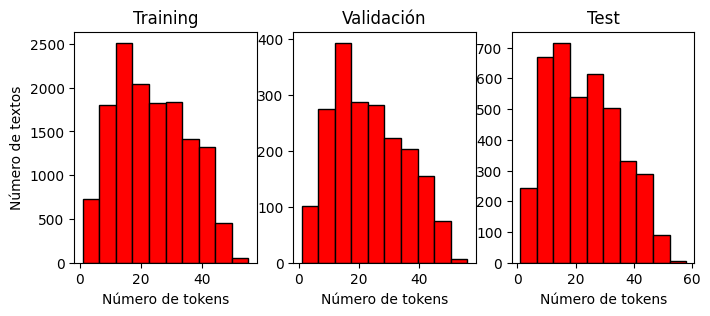

In [69]:

fig, (ax_train, ax_dev, ax_test) = plt.subplots(1, 3, figsize=(8, 3))
# fig.suptitle('Distribución del tamaño de los textos')

ax_train.hist(df_train['length'],  color = 'red', edgecolor = 'black',
         )
ax_train.set_title('Training')
ax_train.set_xlabel('Número de tokens')
ax_train.set_ylabel('Número de textos')


ax_dev.hist(df_dev['length'],  color = 'red', edgecolor = 'black',
         )
ax_dev.set_title('Validación')
ax_dev.set_xlabel('Número de tokens')

ax_test.hist(df_test['length'],  color = 'red', edgecolor = 'black',
         )
ax_test.set_title('Test')
ax_test.set_xlabel('Número de tokens')


Ahora mostramos el histrograma para toda la colección de textos:

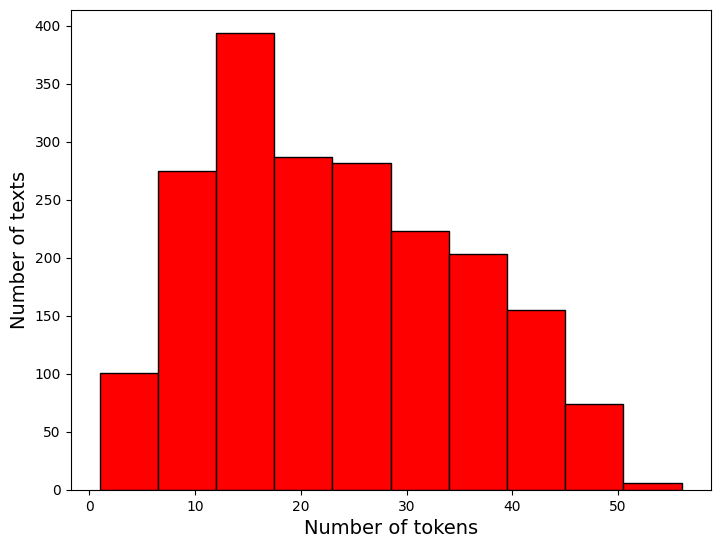

In [70]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.hist(df_dev['length'],  color = 'red', edgecolor = 'black',
         )
ax.set_xlabel('Number of tokens', fontsize=14)
ax.set_ylabel('Number of texts', fontsize=14)

plt.show()


Recuerda que también puedes utilizar la librería seaborn para mostrar este tipo de gráficos:

<ipython-input-71-4e49ebfce380>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['length'], hist=True, kde=True,


<Axes: xlabel='length', ylabel='Density'>

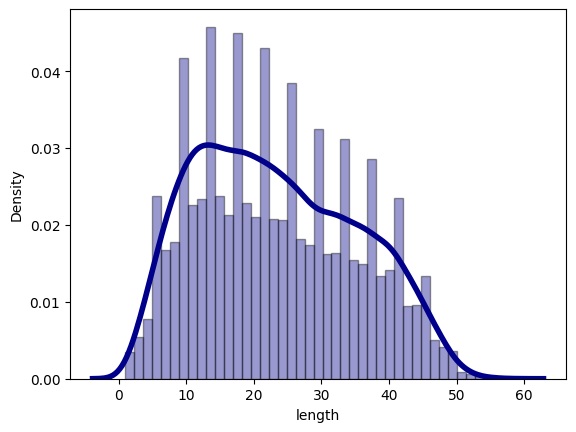

In [71]:
import seaborn as sns

# Density Plot and Histogram of all lenghts of the tweets
sns.distplot(df['length'], hist=True, kde=True,
              color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### Distribución de los tamaños de los textos en función del campo label_sexist



Como las tres divisiones parecen tener una distribución de longitud similar, creamos el gráfico de densidad únicamente para todo el conjunto de datos:


<ipython-input-72-1339e07fd22c>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['length'], hist = False, kde = True,
<ipython-input-72-1339e07fd22c>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['length'], hist = False, kde = True,


Text(0, 0.5, 'Densidad')

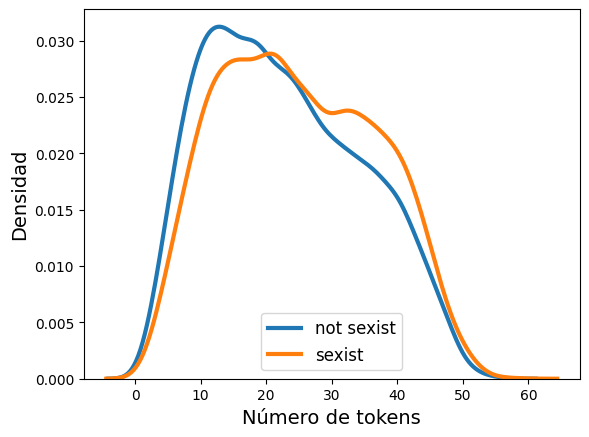

In [72]:
labels = df["label_sexist"].unique()
for name in labels:
    # Subset to the language
    subset = df[df['label_sexist'] == name]

    # Draw the density plot
    sns.distplot(subset['length'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = name)


# Plot formatting
# plt.legend(prop={'size': 12}, title = 'Label')
plt.legend(prop={'size': 12}, loc="lower center")
# plt.title('Density Plot for sexist and non-sexist posts')
plt.xlabel('Número de tokens', fontsize=14)
plt.ylabel('Densidad', fontsize=14)

Podemos observar que la distribución del tamaño de los textos es muy similar en ambas clases: sexistas y no sexistas.
Por tanto, podemos decir que no hay diferencia en cuanto al número de tokens entre los textos sexistas y no sexistas.


### Distribución de los tamaños de los textos en función del campo label_category


<ipython-input-73-4bdba61dfebf>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['length'], hist = False, kde = True,
<ipython-input-73-4bdba61dfebf>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['length'], hist = False, kde = True,
<ipython-input-73-4bdba61dfe

Text(0, 0.5, 'Densidad')

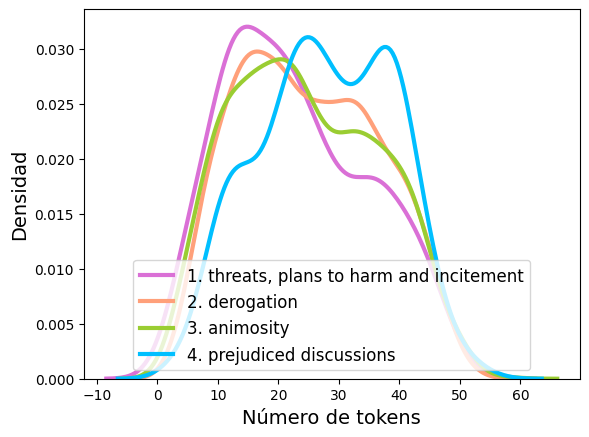

In [73]:
df2 = df[df["label_category"]!='none']

labels = sorted(df2["label_category"].unique())
for name in labels:
    # Subset to the language
    subset = df2[df2['label_category'] == name]

    # Draw the density plot
    sns.distplot(subset['length'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = name, color = dict_color[name])

# Plot formatting
# plt.legend(prop={'size': 10}, title = 'Categories', bbox_to_anchor=(0.7, 0.8), loc="center left" )
# plt.legend(prop={'size': 12}, title = 'Categories', loc="lower center" )
plt.legend(prop={'size': 12}, loc="lower center" )
# plt.title('Density Plot for sexist texts per category (categories)')
plt.xlabel('Número de tokens', fontsize=14 )
plt.ylabel('Densidad', fontsize=14)

Podemos observar que los mensajes  clasificados como amenazas suelen ser más cortas que las clasificadas como discusiones prejuiciosas. Sin embargo, las publicaciones clasificadas con las categorías 2 y 3 tienen una distribución de longitud muy similar.

Así, podemos pensar que los mensajes clasificados en discusiones prejuiciosas suelen ser más largos que el resto de mensajes sexistas. Además, parece que las amenazas suelen ser más cortas que el resto de mensajes sexistas.


In [74]:
df_threat = df2['length'].where(df2['label_category'] == '1. threats, plans to harm and incitement')
df_threat.describe()

count    443.000000
mean      22.909707
std       11.768736
min        2.000000
25%       13.000000
50%       21.000000
75%       32.000000
max       52.000000
Name: length, dtype: float64

In [75]:
df_discus = df2['length'].where(df2['label_category'] == '4. prejudiced discussions')
df_discus.describe()



count    475.000000
mean      27.808421
std       10.907316
min        3.000000
25%       20.000000
50%       28.000000
75%       37.000000
max       54.000000
Name: length, dtype: float64

In [76]:
df2["label_category"].unique()

array(['3. animosity', '2. derogation', '4. prejudiced discussions',
       '1. threats, plans to harm and incitement'], dtype=object)

In [77]:
df_derogation = df2['length'].where(df2['label_category'] == '2. derogation')
df_derogation.describe()

count    2271.000000
mean       24.944958
std        11.475316
min         2.000000
25%        15.000000
50%        24.000000
75%        34.000000
max        53.000000
Name: length, dtype: float64

In [78]:
df_animosity = df2['length'].where(df2['label_category'] == '3. animosity')
df_animosity.describe()

count    1665.000000
mean       24.590390
std        11.893928
min         2.000000
25%        15.000000
50%        23.000000
75%        34.000000
max        58.000000
Name: length, dtype: float64

### Distribución de los tamaños de los textos en función del campo label_vector

<ipython-input-79-d5ed57fbec29>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['length'], hist = False, kde = True,
<ipython-input-79-d5ed57fbec29>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['length'], hist = False, kde = True,
<ipython-input-79-d5ed57fbec

Text(0, 0.5, 'Densidad')

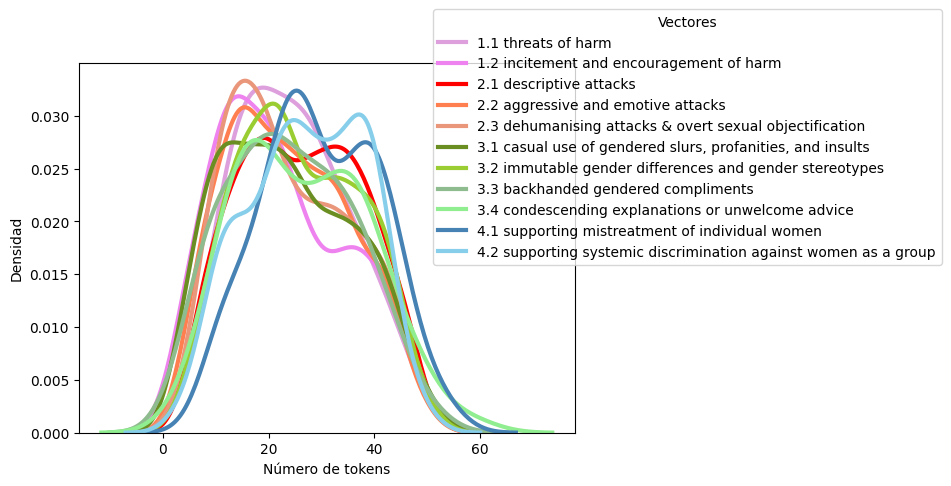

In [79]:
labels = sorted(df2["label_vector"].unique())
for name in labels:
    # Subset to the language
    subset = df2[df2['label_vector'] == name]

    # Draw the density plot
    sns.distplot(subset['length'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = name, color = dict_color3[name])

# Plot formatting
plt.legend(prop={'size': 10}, title = 'Vectores', bbox_to_anchor=(0.7, 0.8), loc="center left" )
# plt.title('Density Plot for sexist texts per category (categories)')
plt.xlabel('Número de tokens')
plt.ylabel('Densidad')

Hay demasiadas subcategorías, por lo que es difícil mostrar la distribución. En este caso, sería mejor utilizar el método describe() de los marcos de datos. O tratar de ir comparando en subconjuntos más pequeños. Por ejemplo, aquí estamos tratando de comparar la longitud para las vectores de la categoría 4:

4.1 supporting mistreatment of individual women
count    107.000000
mean      29.841121
std       10.815912
min        9.000000
25%       22.000000
50%       28.000000
75%       39.000000
max       54.000000
Name: length, dtype: float64

4.2 supporting systemic discrimination against women as a group
count    368.000000
mean      27.217391
std       10.877145
min        3.000000
25%       19.000000
50%       27.000000
75%       37.000000
max       50.000000
Name: length, dtype: float64



<ipython-input-80-b066110ce3f7>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['length'], hist = False, kde = True,
<ipython-input-80-b066110ce3f7>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['length'], hist = False, kde = True,


Text(0, 0.5, '')

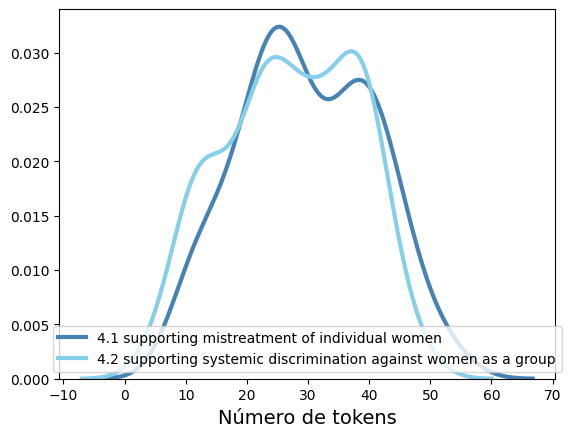

In [80]:
labels = sorted(df2["label_vector"].unique())
for name in labels:
    if name.startswith('4'):
        print(name)
        # Subset to the language
        subset = df2[df2['label_vector'] == name]
        length = subset['length']
        print(length.describe())
        print()
        # Draw the density plot
        sns.distplot(subset['length'], hist = False, kde = True,
                    kde_kws = {'linewidth': 3},
                    label = name, color = dict_color3[name])

# Plot formatting
# plt.legend(prop={'size': 10}, title = 'Categories', bbox_to_anchor=(0.7, 0.8), loc="center left" )
plt.legend(prop={'size': 10}, loc="lower center" )
# plt.title('Density Plot for sexist texts per category (categories)')
plt.xlabel('Número de tokens', fontsize=14)
plt.ylabel('')

Podemos ver que no hay mucha diferencia en cuanto al tamaño de sus textos, en esas dos subcategorías (vectores): 4.1 y 4.2

En este notebook, hemos cargado el dataset de la competición EDOs y hemos estudiado su distribución de clases en cada split, y también la distribución de los tamaños de sus textos.
